In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/dblp-scholar-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/dblp-scholar-reduced/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = ['year'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True)

Number of inputs to dense layer: 14


# Train model 

In [73]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=16384,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 432038 samples, validate on 54004 samples
Epoch 1/1
432038/432038 [==============================] - 5s 11us/step - loss: 0.0031 - acc: 0.9994 - val_loss: 0.0040 - val_acc: 0.9991


# Learning curves

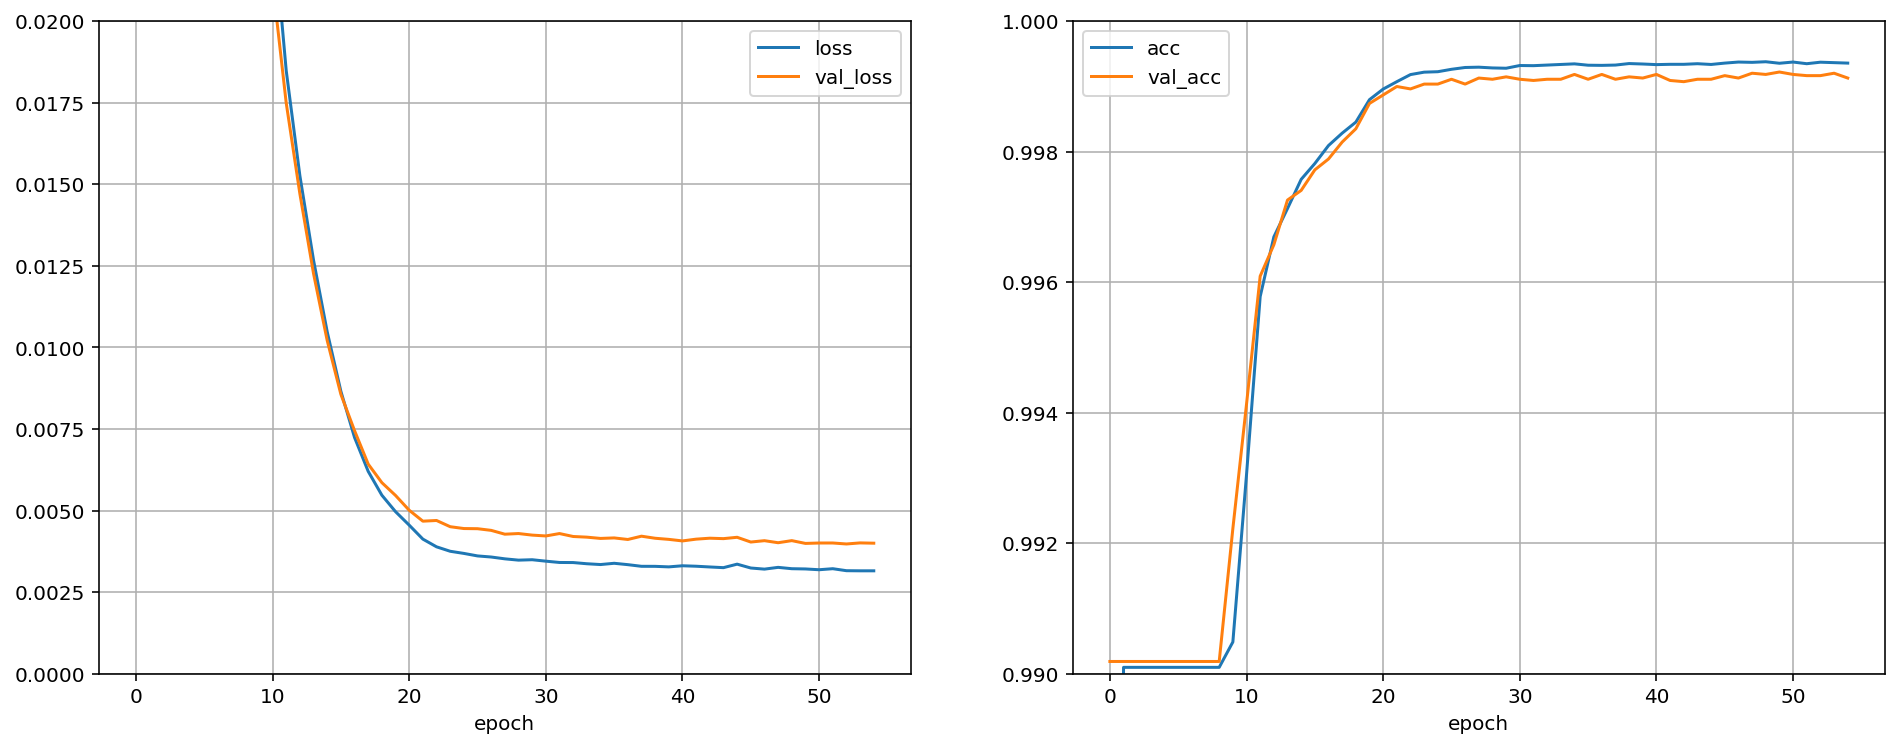

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.02)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(.99, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [52]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     53474
          1       0.98      0.94      0.96       530

avg / total       1.00      1.00      1.00     54004

[[53462    12]
 [   31   499]]


In [53]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,title,authors,venue,year,id2,title,authors,venue,year
34731,journals/tods/Subrahmanian94,amalgamating knowledge bases,subrahmanian,acm database,1994,uoCFHnYrx6wJ,amalgamating knowledge,vs subrahmaniam,acm database systems,0.0
11340,journals/vldb/PapadiasS94,qualitative representation of spatial knowledge in space,papadias sellis,vldb,1994,kEte3P_QB60J,qualitative representation ofspatial knowledge,dpt sellis,vldb journal,0.0
23432,conf/sigmod/OlstonJW03,adaptive filters for continuous queries over distributed data streams,olston jiang widom,sigmod conference,2003,fW0CpIqoV7QJ,widomj 2003 adaptivefiltersforcontinuous queries over distributed data streams,jj olstonc,proceedings of acm sigmod,0.0
35689,journals/sigmod/MeltonE02,an early look at xquery,melton eisenberg,sigmod record,2002,IqEw9ssJ2QAJ,an early look at xquery api for java tm xqj,eisenberg,sigmod record,2004.0
29410,conf/sigmod/FranklinJK96,performance tradeoffs for query processing,franklin jónsson kossmann,sigmod conference,1996,40cq9ovvXn8J,performance tradeoffs for inproc,mj franklin bt jonsson,acm sigmod,0.0


# Save model and histories 

In [54]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-base-1-num-null.csv', index=False)
model.save_weights('../data/models/dblp-scholar-base-1-num-null')

# Test model 

In [4]:
model.load_weights('../data/models/dblp-scholar-base-1-num-null')
y_test_pred = model.predict(X_test, batch_size=8102)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99957   0.99985   0.99971     53467
          1    0.98470   0.95725   0.97078       538

avg / total    0.99942   0.99943   0.99942     54005

[[53459     8]
 [   23   515]]
